# Loading DataSets & Lib's

In [1]:
!pip install datasets

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix

# Data & Model Initilization

In [3]:
# Using XLNet Tokenizer.
dataset = load_dataset('glue', 'mrpc')

tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mrpc/train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

mrpc/validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

mrpc/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Defined Func's

In [4]:
def ensure_contigous(model):
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous() # creates a copy of data with contigous memory.

ensure_contigous(model)

In [5]:
def preprocess_func(demo):
    inputs = tokenizer(demo['sentence1'], demo['sentence2'], truncation=True, padding='max_length', max_length=128)
    inputs['labels'] = demo['label'] # adds the org label into input dict.
    return inputs

encoded_dataset = dataset.map(preprocess_func, batched= True)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

# Traning & Evaluating the Model

In [8]:
from transformers import TrainingArguments, Trainer

traning_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = 'epoch',  # eval = validation.
    save_strategy = 'epoch',
    learning_rate = 5e-5, # lower the learning rate.
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    weight_decay = 0.1,
    warmup_steps = 500,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    logging_steps = 10, # it shows interval when traning-loss & other metrics are loaded.
    logging_dir = './logs'
)

trainer = Trainer(
    model = model,
    args = traning_args,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['validation'],
    tokenizer = tokenizer
)

trainer.train()

results = trainer.evaluate()

/tmp/ipython-input-112481912.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.078400,0.667465
2,0.055600,0.577970
3,0.156100,0.668333
4,0.059600,0.601089
5,0.064200,0.686318


In [ ]:
print(results)

# Calculating Metrics

In [13]:
predictions, true_labels, metrics = trainer.predict(encoded_dataset['validation'])
pred_labels = np.argmax(predictions, axis=1)

print(f'Classification Report \n: {classification_report(true_labels, pred_labels)}')

cm = confusion_matrix(true_labels, pred_labels)

Classification Report 
:               precision    recall  f1-score   support

           0       0.79      0.77      0.78       129
           1       0.89      0.90      0.90       279

    accuracy                           0.86       408
   macro avg       0.84      0.84      0.84       408
weighted avg       0.86      0.86      0.86       408



# Plotting

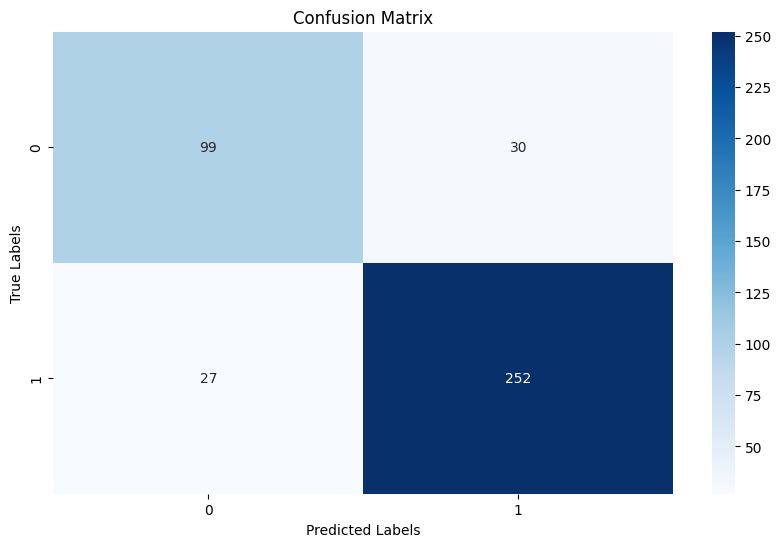

In [14]:
plt.figure(figsize= (10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Saving Model & Tokenizer

In [15]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

save_dir = './saved_model'
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/spiece.model',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [18]:
def make_inference(sen1, sen2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    inputs = tokenizer(sen1, sen2, return_tensors= 'pt', truncation=True, padding='max_length', max_length=128)
    # moves the inputs(input_id, attention masks etc) to same device as inputs.
    inputs = {key : value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits #
        predicted_class = torch.argmax(logits, dim=1)

    return predicted_class

In [21]:
sen1 = 'Amrozi accused his brother, whom he called the witness, of deliberately distorting his evidence.'
sen2 = 'Referring to him as only the witness, Amrozi accused his brother of deliberately distorting his evidence.'

predicted_class = make_inference(sen1, sen2)

if predicted_class == 0:
    print('Non-Pharaphrase')
else:
    print('Pharaphrase')

Pharaphrase


In [23]:
sen1 = 'Amrozi accused his brother, whom he called the witness, of deliberately distorting his evidence.'
sen2 = 'The weather today is sunny with a slight chance of rain in the evening.'

predicted_class = make_inference(sen1, sen2)

if predicted_class == 0:
    print('Non-Pharaphrase')
else:
    print('Pharaphrase')

Non-Pharaphrase
